<a href="https://colab.research.google.com/github/avnishks/colab/blob/main/Exploratory_Data_Analysis_Cleveland_Heart_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# !pip install shap

In [26]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [3]:
df = pd.read_csv('processed.cleveland.data', sep=",", header=None)
df.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
              "exang", "oldpeak", "slope", "ca", "thal", "diseaseStat"]
print("df_shape: ", df.shape)

df_shape:  (303, 14)


In [4]:
df.dtypes

age            float64
sex            float64
cp             float64
trestbps       float64
chol           float64
fbs            float64
restecg        float64
thalach        float64
exang          float64
oldpeak        float64
slope          float64
ca              object
thal            object
diseaseStat      int64
dtype: object

The "ca" and "thal" columns are showing up as `object` Datatype, even though most of the values in those columns are floating point numbers. This points to some of the values in those columns either missing or being a string. A quick glance at the data in those columns shows a few values missing (shown as `?`). First, we should check how many of the data-points are missing:

In [5]:
print("rows with missing 'ca' values: ",
      df[pd.to_numeric(df.ca, errors='coerce').isnull()][["ca", "thal"]], sep='\n')
print('\n')
print("rows with missing 'thal' values: ",
      df[pd.to_numeric(df.thal, errors='coerce').isnull()][["ca", "thal"]], sep='\n')

rows with missing 'ca' values: 
    ca thal
166  ?  3.0
192  ?  7.0
287  ?  7.0
302  ?  3.0


rows with missing 'thal' values: 
      ca thal
87   0.0    ?
266  0.0    ?


Since its only 6 rows, we can drop those particular rows from the dataset. Another option, especially if the number of missing values were significant, could have been to impute these missing values with the sample mean.

In [6]:
df[['ca', 'thal']] = df[['ca', 'thal']].apply (pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.reset_index(drop=True)

Furthermore, I will convert the datatype from float to int in the columns containing only integer values.

In [7]:
print(df['diseaseStat'].value_counts())
df['diseaseStat'].values[df['diseaseStat'].ge(1)] = 1

0    160
1     54
3     35
2     35
4     13
Name: diseaseStat, dtype: int64


In [8]:
cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[cols] = df[cols].applymap(np.int64)
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diseaseStat
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3,3,1
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2,7,1
3,37.0,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0,3,0
4,41.0,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0,3,0


## Data Exploration

#### 1. Let's check the distribution of people with and without the heart disease:

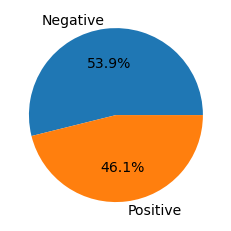

In [9]:
df_target = df.groupby("diseaseStat").size()
plt.pie(df_target.to_numpy(),
        labels = ["Negative", "Positive"],
        autopct='%1.1f%%',
        radius = 1,
        textprops = {"fontsize" : 14}
       ) 
plt.show()

The dataset doesn't seem to be too imbalanced wrt. patients who have a heart condition vs. who don't have a heart condition.

#### 2. Now, let's check this distribution wrt. the sexual orientation of patients:

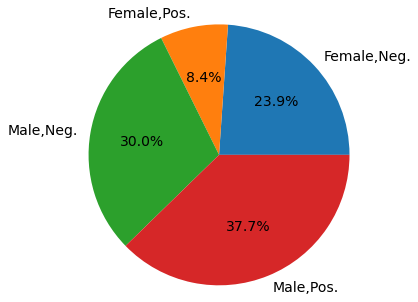

In [12]:
df_sex = df.groupby(["sex","diseaseStat"]).size()
plt.pie(df_sex.values, 
        labels = ["Female,Neg.", "Female,Pos.", "Male,Neg.", "Male,Pos."],
        autopct='%1.1f%%',
        radius = 1.5, 
        textprops = {"fontsize" : 14}
       )
plt.show()

Umm, this is interesting. The dataset itself is skewed towards males by almost 2-to-1 ratio. Furthermore, with the subset of females, the data is skewed towards patients wiout a heart condition by almost 3-to-1 ratio. This is a common instance of imbalance found within medical datasets. We'll have to revisit this at the 'Heart condition prediction' step.

#### 3. Let's check the distribution of heart condition wrt. age of the patients:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


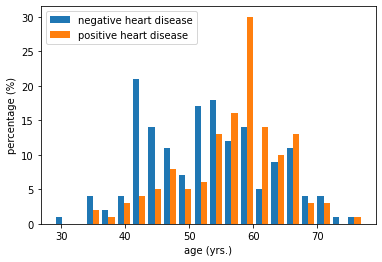

In [13]:
plt.hist([df[df.diseaseStat==0].age, df[df.diseaseStat==1].age],
         bins = 20,
         label = ["negative heart disease","positive heart disease"]
        )
plt.xlabel("age (yrs.)")
plt.ylabel("percentage (%)")
plt.legend()
plt.show()

As expected, we see that older people are at a higher risk of being diagnosed with a heart condition. It peaks around the 60 yrs. age mark in this dataset.

#### 4. Next, let's inspect the heart condition distribution wrt. the Cholestrol measurements:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


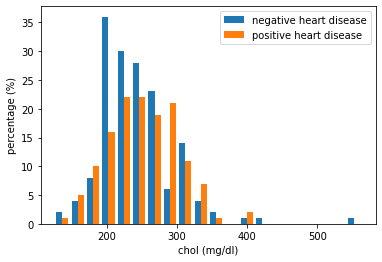

In [14]:
plt.hist([df[df.diseaseStat==0].chol, df[df.diseaseStat==1].chol],
         bins = 20,
         label = ["negative heart disease", "positive heart disease"]
        )
plt.xlabel("chol (mg/dl)")
plt.ylabel("percentage (%)")
plt.legend()
plt.show()

A majority of patients in the dataset have high cholestrol levels. Among these, the risk of heart condition seem to increase as their cholestrol levels get higher than 200 mg/dl. This comports with the available medical literature.

## Heart condition prediction - supervised learning

In [15]:
df_new = pd.get_dummies(data=df, columns=['sex', 'cp', 'exang', 'slope', 'thal'], drop_first = True)
df_new.columns = ['age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'oldpeak', 'ca', 
                 'diseaseStat', 'sex_male', 'cp_atyp_angina', 'cp_non_angina', 'cp_asymptomatic',
                  'exang_induced', 'slope_flat', 'slope_down', 'thal_fixed', 'thal_reversible'
                 ] # renaming features

X = df_new.drop("diseaseStat", 1).values
y = df_new["diseaseStat"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
# define output labels
labels = ['Negative', 'Positive']

# define some plotting functions
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.show()

def plot_roc_curve(fpr, tpr):
    """Plot Reciever Operator Curve using matplotlib.
 
    Args:
        fpr (list): False positive rate.
        tpr (list): True positive rate.
 
    """
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## SVM model

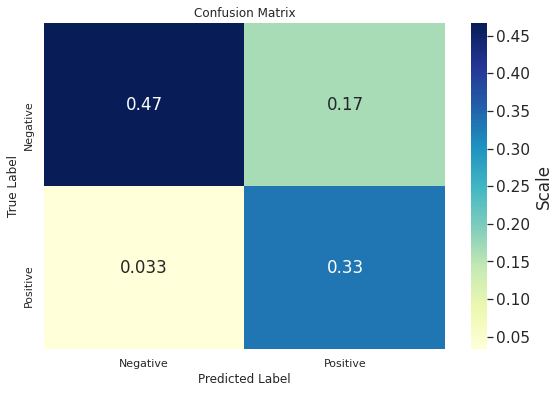

SVM accuracy, recall, precision = 0.80, 0.91, 0.67


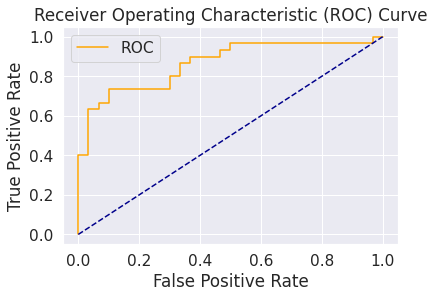

AUC= 0.86


In [20]:
model_svm = SVC(kernel = 'rbf', probability=True)
model_svm.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model_svm.predict(X_test)
cm_svm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm_svm/np.sum(cm_svm),labels)

accuracy_svm  = (cm_svm[0][0] + cm_svm[1][1])/len(y_test)
recall_svm    = cm_svm[1][1]/(cm_svm[1][1] + cm_svm[1][0])
precision_svm = cm_svm[1][1]/(cm_svm[1][1] + cm_svm[0][1])
print('SVM accuracy, recall, precision = {:.2f}, {:.2f}, {:.2f}'.format(accuracy_svm,
                                                        recall_svm,
                                                        precision_svm))

# Plot ROC curve for SVM 
probs_svm = model_svm.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_svm[:, 1])
plot_roc_curve(fpr, tpr)

auc_svm = roc_auc_score(y_test, probs_svm[:, 1])
print('AUC= {:.2f}'.format(auc_svm))

## Logistic Regression model

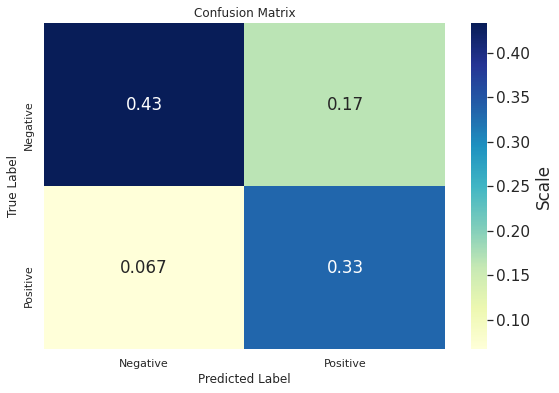

Logistic Regression accuracy, recall, precision = 0.77, 0.83, 0.67


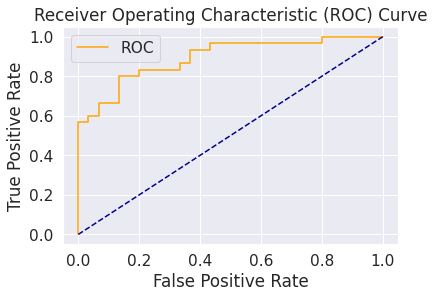

AUC = 0.89


In [21]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model_lr.predict(X_test)
cm_lr  = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm_lr/np.sum(cm_lr),labels)

accuracy_lr  = (cm_lr[0][0] + cm_lr[1][1])/len(y_test)
recall_lr    = cm_lr[1][1]/(cm_lr[1][1] + cm_lr[1][0])
precision_lr = cm_lr[1][1]/(cm_lr[1][1] + cm_lr[0][1])
print('Logistic Regression accuracy, recall, precision = {:.2f}, {:.2f}, {:.2f}'.format(accuracy_lr,
                                                        recall_lr,
                                                        precision_lr))

# Plot ROC curve for LR 
probs_lr = model_lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_lr[:, 1])
plot_roc_curve(fpr, tpr)

auc_lr = roc_auc_score(y_test, probs_lr[:, 1])
print('AUC = {:.2f}'.format(auc_lr))

Decision Tree model

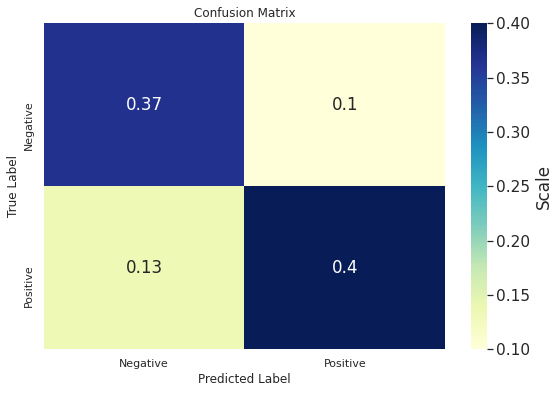

Decision Tree accuracy, recall, precision = 0.77, 0.75, 0.80


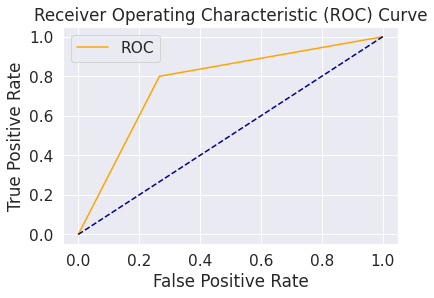

AUC = 0.77


In [22]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model_dt.predict(X_test)
cm_dt  = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm_dt/np.sum(cm_dt),labels)

accuracy_dt  = (cm_dt[0][0] + cm_dt[1][1])/len(y_test)
recall_dt    = cm_dt[1][1]/(cm_dt[1][1] + cm_dt[1][0])
precision_dt = cm_dt[1][1]/(cm_dt[1][1] + cm_dt[0][1])
print('Decision Tree accuracy, recall, precision = {:.2f}, {:.2f}, {:.2f}'.format(accuracy_dt,
                                                        recall_dt,
                                                        precision_dt))

# Plot ROC curve for LR 
probs_dt = model_dt.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_dt[:, 1])
plot_roc_curve(fpr, tpr)

auc_dt = roc_auc_score(y_test, probs_dt[:, 1])
print('AUC = {:.2f}'.format(auc_dt))

## Feature relevance for heart condition prediction

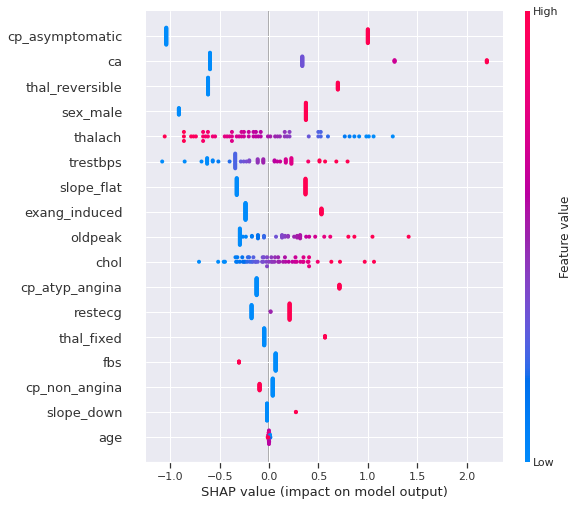

In [27]:
# Logistic regression model features
explainer_lr   = shap.LinearExplainer(model_lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr,
                  X_test,
                  feature_names=list(df_new.drop("diseaseStat", 1).columns)
                 )